# Lesson 13.5 Xavier方法与kaiming方法（HE初始化）

我们介绍**参数初始化优化方法**，也就是针对tanh和Sigmoid激活函数的Xavier方法，以及针对ReLU激活函数的Kaiming方法（HE初始化）。

## 一、Xavier方法

### 1.Xavier初始化参数方法基础理论

&emsp;&emsp;回顾Glorot条件，我们要求正向传播时候数据流经每一层前后的方差一致，并且反向传播时候数据流经每一层，该层梯度前后方差一致。我们将前者称为向前传播条件，后者称为反向传播条件。



我们先看当向前传播条件成立时候，有如下计算过程。首先，数据流至某一层时，该层神经元接收到的数据可以通过如下方法算得：

$$z_j = \sum^n_{i=1}w_ix_i$$

- 其中$z_j$表示当前某层神经元接收到的数据，
- $x_i$表示上一层某神经元传出的数据，
- $w_i$代表连接对应两个神经元之间的权重


如果我们假设w是服从正态分布的，则w服从$(0, \sqrt{\frac{2}{n_{in}+n_{out}}})$的随机变量。据此，我们就能设置每一层的初始参数了。当然，在PyTorch中，可以使用init方法进行初始化。

### 2.Xavier初始化参数执行方法

#### 2.1 PyTorch实现Xavier均匀分布的参数创建

- `torch.nn.init.xavier_uniform_(参数)`进行初始化参数设置。

In [2]:
nn.init.xavier_uniform_?

Signature: nn.init.xavier_uniform_(tensor: torch.Tensor, gain: float = 1.0) -> torch.Tensor
Docstring:
Fills the input `Tensor` with values according to the method
described in `Understanding the difficulty of training deep feedforward
neural networks` - Glorot, X. & Bengio, Y. (2010), using a uniform
distribution. The resulting tensor will have values sampled from
:math:`\mathcal{U}(-a, a)` where

.. math::
    a = \text{gain} \times \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}

Also known as Glorot initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    gain: an optional scaling factor

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
File:      c:\users\hp\python\python310\lib\site-packages\torch\nn\init.py
Type:      function


$fan_{in}$由张量的列决定，$fan_{out}$由张量的行数决定

随机数的范围在$[-a,a]$之间，其中a的表达式为：
$\text{gain} \times \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}$

其中gain为增益系数，用于手动调整均匀分布的边界，暂时不建议调整。

In [3]:
# 创建张量
t = torch.arange(8).reshape(2, 4).float()
t

# fan_in 张量的列，有存在转置关系，此处为4列
# fan_out 2行

tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])

In [4]:
# 实现均匀分布的数值转换
nn.init.xavier_uniform_(t)

tensor([[ 0.5770,  0.3678,  0.2310,  0.3201],
        [-0.7702, -0.1159, -0.2467, -0.5198]])

In [5]:
t  # 该函数会在原对象基础上直接进行修改

tensor([[ 0.5770,  0.3678,  0.2310,  0.3201],
        [-0.7702, -0.1159, -0.2467, -0.5198]])

- Sigmoid激活函数

&emsp;&emsp;接下来，在建模过程中使用Xavier初始化方法测试效果。首先是数据准备与核心参数定义。

In [38]:
#————————————————————————————用Xavier初始化方法测试效果————————————————————————————
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

# 初始核心参数
lr = 0.03
num_epochs = 20


In [39]:
# 设置随机数种子
torch.manual_seed(420)  

# ——————————实例化模型——————————
# =====保留原参数=====
sigmoid_model3 = Sigmoid_class3()       

# =====使用Xavier初始化参数=====
sigmoid_model3_init = Sigmoid_class3()              
# 修改init模型初始参数：修改所有线性层的参数
for m in sigmoid_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)   # 对每一个权重初始化，截距也可以初始化，但是没必要
        
# 创建模型容器
model_l = [sigmoid_model3, sigmoid_model3_init]           
name_l = ['sigmoid_model3', 'sigmoid_model3_init']

Parameter containing:
tensor([[ 0.7995, -0.2561],
        [-0.1097, -0.0529],
        [-0.8137,  0.8860],
        [-0.0984,  0.9770]], requires_grad=True)

Parameter containing:
tensor([[ 0.7130,  0.3764, -0.0196, -0.0096],
        [ 0.0199, -0.8417, -0.2067, -0.4007],
        [-0.0515,  0.1059, -0.6787,  0.6582],
        [ 0.7072,  0.5386,  0.3889,  0.1370]], requires_grad=True)

Parameter containing:
tensor([[-0.6241,  0.3488,  0.3069,  0.8371],
        [-0.8167,  0.7516,  0.6801,  0.1606],
        [ 0.2885,  0.1036, -0.0692,  0.1744],
        [ 0.5015,  0.0987, -0.0787, -0.0286]], requires_grad=True)

Parameter containing:
tensor([[-0.8437, -0.5244,  0.8917,  0.0646]], requires_grad=True)

In [43]:
#————————————————————————————模型训练————————————————————————————
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = 2, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)
                                   
# num_epochs = 2 实际只遍历了1次数据，等于1时没有遍历

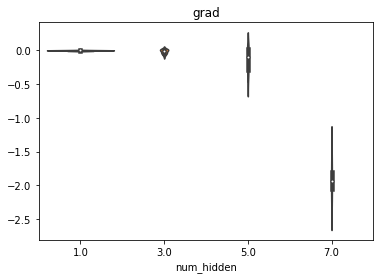

In [44]:
weights_vp(sigmoid_model3, att="grad")

# 第一层出现了明显的梯度消失

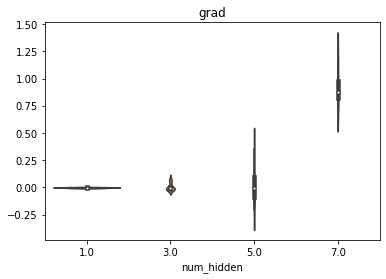

In [55]:
weights_vp(sigmoid_model3_init, att="grad")

我们发现，在num_epochs取值为2的时候（只迭代了一轮），经过Xavier初始化的模型梯度整体更加稳定，并且没有出现梯度消失的情况，反观原始模型sigmoid_model2，第一层的梯度已经非常小了，已经出现了梯度消失的倾向。

In [56]:
#————————————————————————————增加迭代轮数————————————————————————————
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

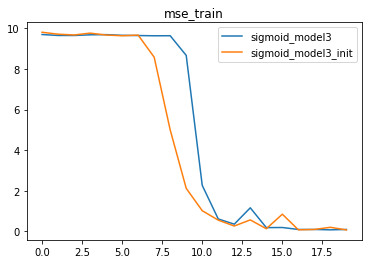

In [57]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

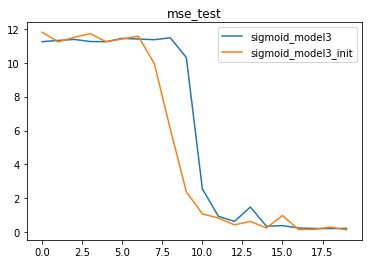

In [58]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

&emsp;&emsp;由此我们可知，Xavier初始化的作用核心在于保证各层梯度取值的平稳分布，从而确保各层模型学习的有效性，最终在模型结果的表现上。

- Xavier初始化参数的模型学习效率更高、收敛速度更快

&emsp;&emsp;当然，在一些极端情况下，Xavier初始化效果会更加明显。我们以四层sigmoid隐藏层的神经网络为例，观察Xavier初始化在规避梯度消失问题时的效果。

In [59]:
#————————————————————————————4个隐藏层的sigmoid的情况————————————————————————————

# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型
sigmoid_model4 = Sigmoid_class4()                   # 保留原参数
sigmoid_model4_init = Sigmoid_class4()              # 使用Xavier初始化参数

# 修改init模型初始参数
for m in sigmoid_model4_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
# 创建模型容器
model_l = [sigmoid_model4, sigmoid_model4_init]           
name_l = ['sigmoid_model4', 'sigmoid_model4_init']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Parameter containing:
tensor([[ 0.8858,  0.6076],
        [ 0.7526,  0.3184],
        [-0.2945,  0.9237],
        [ 0.7596, -0.6387]], requires_grad=True)

Parameter containing:
tensor([[-0.0020, -0.2599, -0.8290,  0.0234],
        [-0.5126, -0.1948, -0.2230,  0.7317],
        [ 0.3355, -0.7767,  0.4933,  0.5650],
        [ 0.3391,  0.3513,  0.3385,  0.0232]], requires_grad=True)

Parameter containing:
tensor([[-0.7911, -0.4265,  0.5541,  0.2841],
        [ 0.6846,  0.2079,  0.8334, -0.3973],
        [-0.4116,  0.3072, -0.4335,  0.3472],
        [ 0.0940, -0.3414,  0.2058,  0.8155]], requires_grad=True)

Parameter containing:
tensor([[ 0.4660, -0.8182,  0.3571,  0.5147],
        [ 0.6018, -0.2091,  0.7026,  0.6874],
        [-0.0111, -0.1543,  0.6806,  0.1008],
        [ 0.3697,  0.0858,  0.4200, -0.2422]], requires_grad=True)

Parameter containing:
tensor([[-0.6746,  0.9178,  0.5031,  0.2799]], requires_grad=True)

Text(0.5, 1.0, 'mse_train')

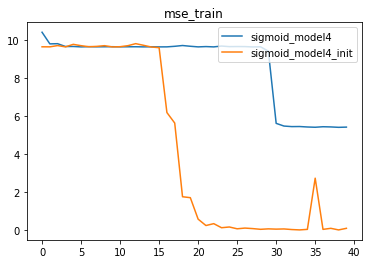

In [60]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

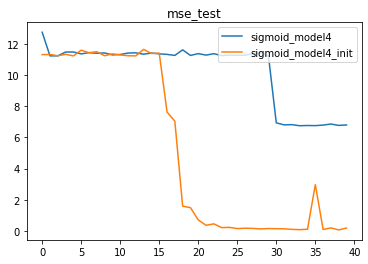

In [61]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

sigmoid_model4是Lesson 13.2中出现严重梯度消失的模型，由于前几层基本丧失学习能力，sigmoid_model4本身效果并不好。但加入Xavier初始化之后，我们发现，init模型能够极大程度规避梯度消失问题，从而获得更好的效果。


- tanh激活函数

不过正如此前所说，相比于sigmoid激活函数，Xavier初始化方法更适用于tanh激活函数，核心原因在于tanh激活函数本身能够生成Zero-centered Data，配合Xavier初始化生成的参数，能够更好的确保各层梯度平稳、确保各层平稳学习。

我们以三层tanh激活函数隐藏层的神经网络为例，测试Xavier初始化效果。

In [64]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [65]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
tanh_model3 = tanh_class3()                   # 保留原参数
tanh_model3_init = tanh_class3()              # 使用Xavier初始化参数

In [66]:
# 设置随机数种子
torch.manual_seed(420)  

# 修改init模型初始参数
for m in tanh_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_init]           
name_l = ['tanh_model3', 'tanh_model3_init']

# 核心参数
lr = 0.03
num_epochs = 20

Parameter containing:
tensor([[ 0.6107, -0.6019],
        [ 0.9517, -0.7944],
        [-0.3051, -0.6891],
        [ 0.7712,  0.3751]], requires_grad=True)

Parameter containing:
tensor([[-0.4319, -0.6698, -0.5014, -0.1671],
        [-0.4420,  0.6311, -0.3644, -0.5666],
        [-0.2672, -0.8457, -0.4206, -0.4725],
        [ 0.1864,  0.7043,  0.0935, -0.5047]], requires_grad=True)

Parameter containing:
tensor([[ 0.3565, -0.3687, -0.4099, -0.1660],
        [-0.4519,  0.0952,  0.7030,  0.1181],
        [ 0.5231, -0.7523, -0.6813, -0.1152],
        [ 0.0008,  0.5406, -0.7617,  0.3613]], requires_grad=True)

Parameter containing:
tensor([[-0.9402,  0.1767,  0.7240,  0.1511]], requires_grad=True)

In [67]:
# 模型训练
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = 2, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

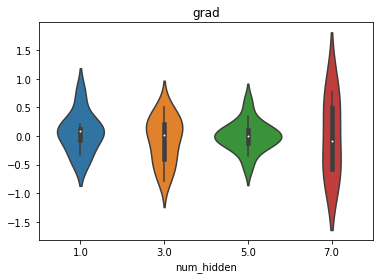

In [68]:
weights_vp(tanh_model3, att="grad")

# 层间梯度不均衡

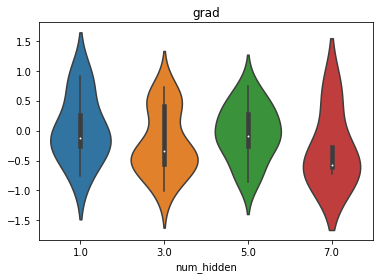

In [69]:
weights_vp(tanh_model3_init, att="grad")

In [70]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
tanh_model3 = tanh_class3()                   # 保留原参数
tanh_model3_init = tanh_class3()              # 使用Xavier初始化参数

# 修改init模型初始参数
for m in tanh_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_init]           
name_l = ['tanh_model3', 'tanh_model3_init']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Parameter containing:
tensor([[ 0.7995, -0.2561],
        [-0.1097, -0.0529],
        [-0.8137,  0.8860],
        [-0.0984,  0.9770]], requires_grad=True)

Parameter containing:
tensor([[ 0.7130,  0.3764, -0.0196, -0.0096],
        [ 0.0199, -0.8417, -0.2067, -0.4007],
        [-0.0515,  0.1059, -0.6787,  0.6582],
        [ 0.7072,  0.5386,  0.3889,  0.1370]], requires_grad=True)

Parameter containing:
tensor([[-0.6241,  0.3488,  0.3069,  0.8371],
        [-0.8167,  0.7516,  0.6801,  0.1606],
        [ 0.2885,  0.1036, -0.0692,  0.1744],
        [ 0.5015,  0.0987, -0.0787, -0.0286]], requires_grad=True)

Parameter containing:
tensor([[-0.8437, -0.5244,  0.8917,  0.0646]], requires_grad=True)

Text(0.5, 1.0, 'mse_train')

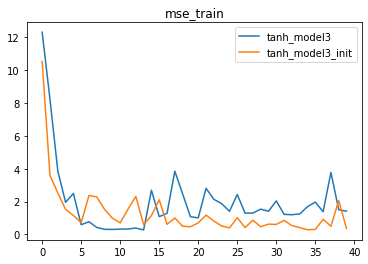

In [71]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

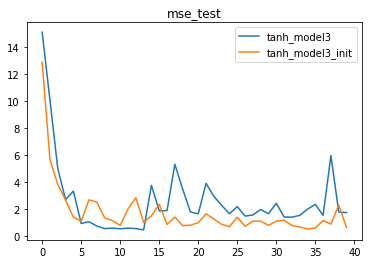

In [72]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

同样，能够看出经过Xavier参数初始化后的模型梯度更加平稳，进而我们判断，经过初始化之后的模型初始迭代时收敛速度更快

#### 2.2 PyTorch实现Xavier高斯分布的参数创建

用`torch.nn.init.xavier_normal_`进行初始化参数设置。

In [73]:
torch.nn.init.xavier_normal_?

Signature: torch.nn.init.xavier_normal_(tensor: torch.Tensor, gain: float = 1.0) -> torch.Tensor
Docstring:
Fills the input `Tensor` with values according to the method
described in `Understanding the difficulty of training deep feedforward
neural networks` - Glorot, X. & Bengio, Y. (2010), using a normal
distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}

Also known as Glorot initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    gain: an optional scaling factor

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.xavier_normal_(w)
File:      c:\users\hp\python\python310\lib\site-packages\torch\nn\init.py
Type:      function


$$\text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}$$

当然，修改参数的方法也是相同的，例如:

In [75]:
#————————————————————————————torch.nn.init.xavier_normal_进行初始化参数设置。————————————————————————————

# 实例化模型
sigmoid_model2 = Sigmoid_class2()                  

# 修改init模型初始参数
for m in sigmoid_model2.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

Parameter containing:
tensor([[-0.0735, -0.0941],
        [-0.1332, -0.9259],
        [ 0.2803, -0.3529],
        [-0.1686,  0.8779]], requires_grad=True)

Parameter containing:
tensor([[-0.8206,  0.2159, -0.9876, -0.0095],
        [-0.1434,  0.5362, -0.3858,  0.0785],
        [-0.0542,  0.5039,  0.9254,  0.6225],
        [-0.6864,  0.1003,  0.4815, -0.8140]], requires_grad=True)

Parameter containing:
tensor([[-0.7034,  0.4468, -0.4812, -0.4097]], requires_grad=True)

其他测试初始化效果的相关实验和此前操作流程一致。

从理论上来说，均匀分布和高斯分布并没有根本性区别，二者任选其一使用即可。不过也有一些不是很严谨的实验证明了均匀分布比高斯分布能够产生相对较大的梯度，因而模型学习效果会更好。

## 二、Kaiming方法（HE初始化）

### 1.HE初始化基础理论

&emsp;&emsp;尽管Xavier初始化能够在Sigmoid和tanh激活函数叠加的神经网络中起到一定的效果，但由于ReLU激活函数属于非饱和类激活函数，并不会出现类似Sigmoid和tanh激活函数使用过程中可能存在的梯度消失或梯度爆炸问题，反而因为ReLU激活函数的不饱和特性，ReLU激活函数的叠加极有可能出现神经元活性消失的问题，很明显，该类问题无法通过Xavier初始化解决。

&emsp;&emsp;当然，He初始化也遵循Glorot条件，即参数初始化结果要求正向传播时各层接收到的数据方差保持一致、反向传播时各层参数梯度的方差保持一致。

当然，根据参数方差，我们就能确定参数满足均匀分布时的边界，以及满足高斯分布时的基本形态。均匀分布时$bound = \sqrt{3var}$，因此参数分布区间为:$$(-\sqrt{\frac{6}{fan_{in}}}, \sqrt{\frac{6}{fan_{in}}})$$

### 2.HE初始化在PyTorch中实现

#### 2.1 PyTorch实现HE初始化的均匀分布参数创建

我们可以使用`torch.nn.init.kaiming_uniform_`进行初始化参数设置。

In [76]:
nn.init.kaiming_uniform_?

Signature:
nn.init.kaiming_uniform_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
uniform distribution. The resulting tensor will have values sampled from
:math:`\mathcal{U}(-\text{bound}, \text{bound})` where

.. math::
    \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        back

相关参数解释:
- mode：参数表示选择带入扇入还是扇出的神经元个数进行计算，正如前文所说，理论上二者对建模没有明显影响，可任选其一，但实际由于模型个体差异，在实际使用过程中还是略有差异，我们可以根据实际效果进行选择；
- a：为使用ReLU变种激活函数时的修正系数；
- nonlinearity：表示所选用的变种ReLU激活函数类型，需要配合a参数使用，相关使用方法我们将在后续介绍ReLU变种激活函数的使用时一并介绍。

$$bound = \sqrt{\frac{6}{(1+a^2)fan_{in}}}$$

和Xavier方法一样，kaiming方法直接对张量的值进行修改，并且张量列数表示$fan_{in}$的个数，行数表示$fan_{out}$的个数，据此，我们简单测试下公式正确性。

In [77]:
t = torch.arange(12).reshape(2, 6).float()
t

# 2是fan_out
# 6是fan_in

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.]])

In [78]:
#————————————————————————————kaiming_uniform_()————————————————————————————
# 设置随机数种子
torch.manual_seed(420)  
torch.nn.init.kaiming_uniform_(t)         # 此时扇入个数是6

tensor([[ 0.6107, -0.6019,  0.9517, -0.7944, -0.3051, -0.6891],
        [ 0.7712,  0.3751, -0.4988, -0.7734, -0.5790, -0.1929]])

In [79]:
# 设置随机数种子
torch.manual_seed(420)  
torch.nn.init.kaiming_uniform_(t,a=1)         # 此时分母是

tensor([[ 0.4318, -0.4256,  0.6730, -0.5617, -0.2157, -0.4873],
        [ 0.5453,  0.2653, -0.3527, -0.5469, -0.4094, -0.1364]])

In [80]:
math.sqrt(0.5)

0.7071067811865476

In [81]:
t = torch.arange(18).reshape(6, 3).float()
t

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.]])

In [ ]:
# 设置随机数种子
torch.manual_seed(420)  
torch.nn.init.kaiming_uniform_(t)        # 此时扇入个数是3

# 6 是fan_out

接下来，尝试在建模过程中使用kaiming方法，验证是否能够加快迭代效率，并且规避神经元活性失效问题。


> HE初始化如何帮助模型规避Dead ReLU Problem？  
> 核心在于模型初始化时如果参数完全随机选择，就有可能出现初始参数全部输出0的结果，而通过HE初始化的参数不会出现上述情况。

In [82]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, 1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

# 初始核心参数
lr = 0.001  # 学习率设置的较小
num_epochs = 20


In [83]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型 3个隐藏层的ReLU模型
relu_model3 = ReLU_class3()                   # 保留原参数
relu_model3_init = ReLU_class3()              # 使用HE初始化参数

# 修改init模型初始参数
for m in relu_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        
# 创建模型容器
model_l = [relu_model3, relu_model3_init]           
name_l = ['relu_model3', 'relu_model3_init']

Parameter containing:
tensor([[ 1.3847, -0.4435],
        [-0.1899, -0.0916],
        [-1.4094,  1.5347],
        [-0.1705,  1.6922]], requires_grad=True)

Parameter containing:
tensor([[ 1.0084,  0.5323, -0.0277, -0.0135],
        [ 0.0282, -1.1904, -0.2923, -0.5667],
        [-0.0729,  0.1498, -0.9598,  0.9308],
        [ 1.0001,  0.7617,  0.5500,  0.1938]], requires_grad=True)

Parameter containing:
tensor([[-0.8826,  0.4933,  0.4340,  1.1838],
        [-1.1550,  1.0630,  0.9618,  0.2271],
        [ 0.4080,  0.1464, -0.0979,  0.2467],
        [ 0.7092,  0.1396, -0.1113, -0.0405]], requires_grad=True)

Parameter containing:
tensor([[-0.9433, -0.5863,  0.9970,  0.0722]], requires_grad=True)

In [84]:
# 训练模型 
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

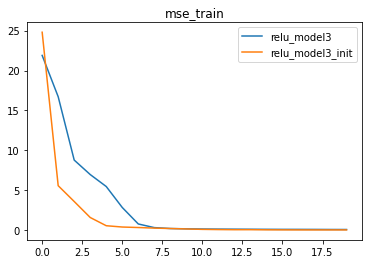

In [85]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

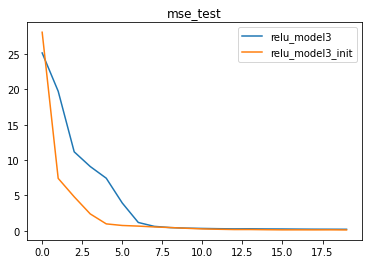

In [86]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')


# 我们发现，使用HE初始化之后模型收敛速度明显提升。

#### 2.2 PyTorch实现HE初始化的正态分布参数创建

使用`torch.nn.init.kaiming_normal_`来进行满足正态分布的初始化参数设置



In [87]:
nn.init.kaiming_normal_?

Signature:
nn.init.kaiming_normal_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
normal distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        backwards pass.
    nonlinear

实际上，PyTorch中所使用的HE初始化时，初始参数的方差为：

$$Var(w) = \frac{2}{(1+a^2)fan_{in}}$$

其中a为ReLU变种激活函数的修正系数，需要配合ReLU变种激活函数共同使用，扇入神经元个数和扇出神经元个数等效，并且$$std(w) = \sqrt{\frac{2}{(1+a^2)fan_{in}}}$$


- 简单实践

In [88]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
relu_model3 = ReLU_class3()                   # 保留原参数

relu_model3_init = ReLU_class3()              # 使用HE初始化参数
# 修改init模型初始参数
for m in relu_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        
# 创建模型容器
model_l = [relu_model3, relu_model3_init]           
name_l = ['relu_model3', 'relu_model3_init']

Parameter containing:
tensor([[ 0.4132,  1.2154],
        [-0.0425, -1.3647],
        [-0.5896,  2.1108],
        [ 0.2548,  0.1661]], requires_grad=True)

Parameter containing:
tensor([[ 0.5093, -0.2730, -0.1495,  1.4481],
        [ 1.5209,  1.1812,  0.8868, -0.7768],
        [ 0.6132, -0.8655, -0.3035, -0.1526],
        [ 0.2752, -0.5203, -0.7091, -0.5119]], requires_grad=True)

Parameter containing:
tensor([[ 0.7865, -0.0605,  0.6548, -0.9418],
        [-1.1811,  0.8337,  0.5161, -0.8076],
        [ 0.6926,  0.9038, -0.4330, -0.1764],
        [-0.4042,  0.3451, -0.5829, -0.0914]], requires_grad=True)

Parameter containing:
tensor([[-0.7091,  0.1566, -0.7193, -0.9234]], requires_grad=True)

In [89]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

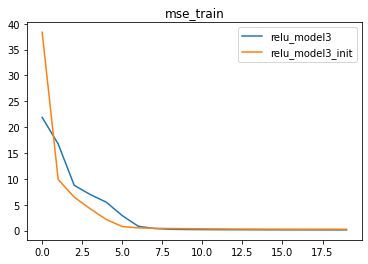

In [90]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

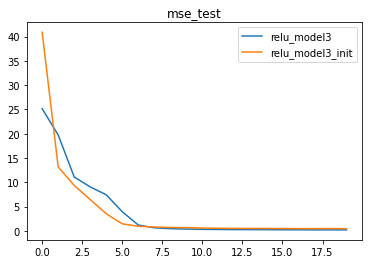

In [91]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

同样，经过HE初始化后的参数，模型收敛速度更快，也证明了HE初始化的有效性。

## 三、参数初始化的作用局限

&emsp;&emsp;截止目前，我们讨论了围绕Glorot条件进行的参数初始化方法，当然，合理的设置初始参数值能够一定程度上使得模型各层都得到有效的学习，模型训练过程更加平稳、收敛速度也更快。但由于我们设置的是初始条件，伴随着模型不断训练，由于受到激活函数导函数本身特性影响，仍然有可能在迭代过程中出现梯度不均衡的现象。

&emsp;&emsp;然而模型一旦开始训练，我们是不能手动参与修改模型参数的。那此时应该如何处理梯度不均衡的问题呢？我们知道，影响梯度计算的三个核心因素，分别是**参数状态值、激活值和输入的数据**，参数状态值由模型迭代的数学过程决定，激活值很大程度上由我们所选取的激活函数决定，如果从Glorot条件入手，我们就只剩下一个可以人工修改的选项：每一个线性层接收到的数据。